# embedding analytics

some functions to assess the usefulness of embeddings

TODO: compare to multiple tracks

## imports

In [1]:
import os
import mido
import torch
import random
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt

plt.style.use("dark_background")

In [2]:
VALID_EXTENSIONS = (".mid", ".midi")
WEIGHT_PRS = True
parent_dir = "/media/nova/Datasets/sageev-midi/20250110/segmented/"
# test_file = "/media/nova/Datasets/sageev-midi/20250110/segmented/20240511-088-03/20240511-088-03_0169-0174.mid"
test_file = "/media/nova/Datasets/sageev-midi/20250110/segmented/20240121-070-01/20240121-070-01_0041-0047.mid"

## representation functions

currently supported: pitch histogram (weighted & unweighted), spectrogram diffusion embeddings

to add: clamp embeddings, blurred piano rolls

In [3]:
def load_embedding(midi_path: str) -> torch.tensor:
    midi_name = os.path.splitext(os.path.basename(midi_path))[0]
    embedding_path = os.path.join("..", "data", "embeddings", midi_name + ".pt")
    return torch.load(embedding_path, weights_only=False).flatten()

In [4]:
def load_pr(midi_path: str) -> np.ndarray:
    return pretty_midi.PrettyMIDI(midi_path).get_pitch_class_histogram(
        use_duration=WEIGHT_PRS, use_velocity=WEIGHT_PRS
    )

In [5]:
# weighted piano roll
# representation_function = lambda x: load_pr(x)

# spectrogram diffusion embeddings
representation_function = lambda x: load_embedding(x)

## similarity functions

currently supported: cosine similarity

to add: euclidean, manhattan, ...?

In [6]:
# cosine similarity
similarity_metric = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

## load filesystem

In [7]:
# extract representations for all segments
other_tracks = random.sample(
    [os.path.join(parent_dir, track) for track in os.listdir(parent_dir)], 2
)
print(other_tracks)

['/media/nova/Datasets/sageev-midi/20250110/segmented/20240312-080-05', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240402-065-01']


In [8]:
midi_file = os.path.basename(test_file)

midi_segments = []
for p_midi in other_tracks + [os.path.dirname(test_file)]:
    midi_segments += [
        os.path.join(p_midi, segment)
        for segment in os.listdir(p_midi)
        if segment.endswith(VALID_EXTENSIONS)
    ]
print(f"midi path is {p_midi}")
print(f"midi file is {midi_file}")
print(f"midi segments ({len(midi_segments)}) is {midi_segments[:3]}")

try:
    segment_index = midi_segments.index(test_file)
    print(f"segment index is {segment_index}")
except ValueError:
    print(f"ERROR: couldn't find key midi file in segment list")

midi path is /media/nova/Datasets/sageev-midi/20250110/segmented/20240121-070-01
midi file is 20240121-070-01_0041-0047.mid
midi segments (138) is ['/media/nova/Datasets/sageev-midi/20250110/segmented/20240312-080-05/20240312-080-05_0179-0185.mid', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240312-080-05/20240312-080-05_0029-0035.mid', '/media/nova/Datasets/sageev-midi/20250110/segmented/20240312-080-05/20240312-080-05_0077-0083.mid']
segment index is 93


## calculate the similarities

In [9]:
segment_representations = [
    representation_function(segment) for segment in midi_segments
]

# get the representation of the specified segment
target_representation = representation_function(test_file)

# calculate similarity for all segments
similarities = [
    similarity_metric(representation_function(test_file), representation)
    for representation in segment_representations
]
# do a quick validity test
key_sim = similarity_metric(
    target_representation, segment_representations[segment_index]
)
print(f"self-similarity for key midi file is {key_sim:.05f}")

# normalize similarities to [0, 1] range
min_similarity, max_similarity = min(similarities), max(similarities)
normalized_similarities = [
    (sim - min_similarity) / (max_similarity - min_similarity) for sim in similarities
]

self-similarity for key midi file is 1.00000


In [10]:
len(similarities)

138

## similarity plot

visualize the similarity of the chosen segment against the entire track

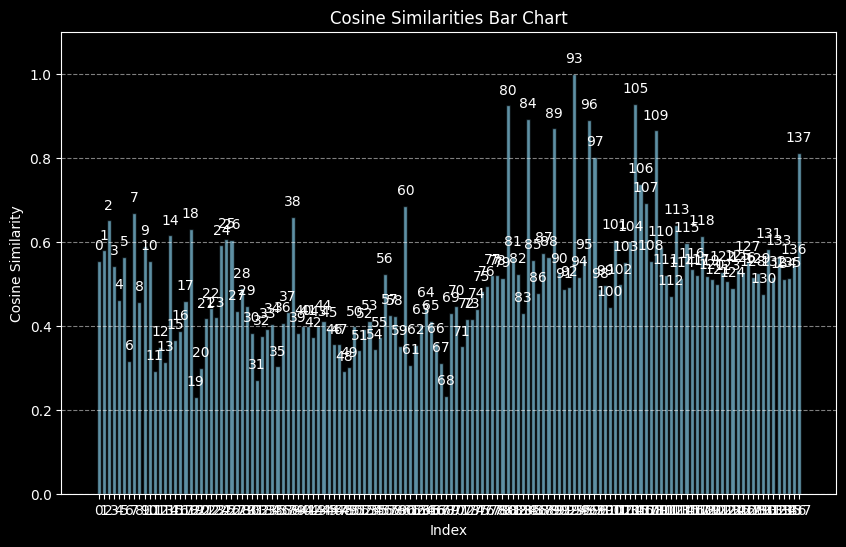

In [22]:
def plot_similarity_bars(similarities: list):
    """Plot a bar chart of normalized cosine similarities with indices labeled above each bar.

    Args:
        similarities (list): A list of normalized cosine similarities (values between 0 and 1).
    """
    indices = np.arange(len(similarities))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(indices, similarities, color="skyblue", edgecolor="black", alpha=0.7)

    # add labels above each bar
    for idx, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.02,  # slightly above the bar
            f"{idx}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.xlabel("Index")
    plt.ylabel("Cosine Similarity")
    plt.title("Cosine Similarities Bar Chart")
    plt.xticks(indices)
    plt.ylim(0, 1.1)  # set y-axis range slightly above 1 for better label visibility
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()


plot_similarity_bars(similarities)

## file playback

listen to the original file, best 3 matches, and worst match, within the same track, not within the entire dataset.

In [12]:
from midi_player import MIDIPlayer
from midi_player.stylers import dark

matched_sims = sorted(
    list(zip(midi_segments, similarities)), key=lambda x: x[1], reverse=True
)

### original file

In [13]:
print(
    f"{os.path.basename(matched_sims[0][0])} has similarity {matched_sims[0][1]:.03f} to {midi_file}"
)
MIDIPlayer(matched_sims[0][0], 300, styler=dark)

20240121-070-01_0041-0047.mid has similarity 1.000 to 20240121-070-01_0041-0047.mid


### best match

In [29]:
print(
    f"{os.path.basename(matched_sims[1][0])} has similarity {similarities[19]:.03f} to {midi_file}"
)
MIDIPlayer(midi_segments[19], 300, styler=dark)

20240121-070-01_0027-0034.mid has similarity 0.230 to 20240121-070-01_0041-0047.mid


### second best match

In [15]:
print(
    f"{os.path.basename(matched_sims[2][0])} has similarity {matched_sims[2][1]:.03f} to {midi_file}"
)
MIDIPlayer(matched_sims[2][0], 300, styler=dark)

20240121-070-01_0020-0027.mid has similarity 0.925 to 20240121-070-01_0041-0047.mid


### third best match

In [16]:
print(
    f"{os.path.basename(matched_sims[3][0])} has similarity {matched_sims[3][1]:.03f} to {midi_file}"
)
MIDIPlayer(matched_sims[3][0], 300, styler=dark)

20240121-070-01_0013-0020.mid has similarity 0.893 to 20240121-070-01_0041-0047.mid


### worst match

In [17]:
print(
    f"{os.path.basename(matched_sims[-1][0])} has similarity {matched_sims[-1][1]:.03f} to {midi_file}"
)
MIDIPlayer(matched_sims[-1][0], 400, styler=dark)

20240312-080-05_0000-0005.mid has similarity 0.230 to 20240121-070-01_0041-0047.mid
